In [1]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
import statistics

In [3]:
# Create environment
env = gym.make('CartPole-v1')

In [4]:
env.observation_space

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

In [5]:
env.spec

EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')

In [6]:
class Discretizer:
    def __init__(self, bins):
        self.bins = bins
        self.state_ranges = {
            'cart_position': (-4.8000002e+00, 4.8000002e+00),
            'cart_velocity': (-3.4028235e+38, 3.4028235e+38),
            'pole_angle': (-4.1887903e-01, 4.1887903e-01),
            'pole_angular_velocity': (-3.4028235e+38, 3.4028235e+38)
        }
        self.discretizers = {
            key: np.linspace(self.state_ranges[key][0], self.state_ranges[key][1], self.bins + 1)[1:-1]
            for key in self.state_ranges
        }

    def discretize(self, state):
        cart_position, cart_velocity, pole_angle, pole_angular_velocity = state.flatten()
        discretized_state = (
            np.digitize(cart_position, self.discretizers['cart_position']),
            np.digitize(cart_velocity, self.discretizers['cart_velocity']),
            np.digitize(pole_angle, self.discretizers['pole_angle']),
            np.digitize(pole_angular_velocity, self.discretizers['pole_angular_velocity'])
        )
        return discretized_state

In [7]:
class TrackCellsCallback(BaseCallback):
    def __init__(self, discretizer, verbose=0):
        super(TrackCellsCallback, self).__init__(verbose)
        self.discretizer = discretizer
        self.visited_cells = set()
        self.visited_cells_per_episode = set()
        self.total_cells = discretizer.bins ** 4  # Total possible cells
        self.percentage_explored_over_timesteps = []
        self.episode_cells_counts = []

    def _on_step(self) -> bool:
        obs = self.locals['new_obs']
        discretized_state = self.discretizer.discretize(obs)
        self.visited_cells.add(discretized_state)
        self.visited_cells_per_episode.add(discretized_state)
        percentage_explored = len(self.visited_cells) / self.total_cells * 100
        self.percentage_explored_over_timesteps.append(percentage_explored)

        if self.locals['dones'][0]:  # Check if the episode has ended
            percentage_explored_per_episode = len(self.visited_cells_per_episode) / self.total_cells * 100
            self.episode_cells_counts.append(percentage_explored_per_episode)
            self.visited_cells_per_episode.clear()  # Reset for the next episode
            
        return True

    def plot_percentage_over_timesteps(self):
        plt.plot(range(len(self.percentage_explored_over_timesteps)), self.percentage_explored_over_timesteps)
        plt.xlabel('Timesteps')
        plt.ylabel('Percentage of Unique Cells Visited')
        plt.title('Exploration Over Timesteps')
        plt.show()

    def plot_percentage_over_episodes(self):
        plt.plot(range(len(self.episode_cells_counts)), self.episode_cells_counts)
        plt.xlabel('Episodes')
        plt.ylabel('Percentage of Unique Cells Visited')
        plt.title('Exploration Over Episodes')
        plt.show()

In [8]:
class TrackCumulativeRewardsCallback(BaseCallback):
    def __init__(self, verbose=0, block_size=100):
        super(TrackCumulativeRewardsCallback, self).__init__(verbose)
        self.current_episode_reward = 0
        self.cumulative_rewards_per_episode = []
        self.block_rewards = []  # Stores rewards for current block
        self.block_size = block_size  # Number of timesteps per block
        self.block_variances = []  # Stores variance for each block

    def _on_step(self) -> bool:
        reward = self.locals['rewards'][0]  # rewards is a list, we take the first element
        self.current_episode_reward += reward
        self.block_rewards.append(reward)

        #calculating cumulative reward per episode
        if self.locals['dones'][0]:  # Check if the episode has ended
            self.cumulative_rewards_per_episode.append(self.current_episode_reward)
            self.current_episode_reward = 0  # Reset for the next episode
        
        #calculating reward variance per timesteps block
        if len(self.block_rewards) == self.block_size:
            self.calculate_block_variance()
        
        return True

    
    def plot_cumulative_rewards_over_episodes(self):
        plt.plot(range(len(self.cumulative_rewards_per_episode)), self.cumulative_rewards_per_episode)
        plt.xlabel('Episodes')
        plt.ylabel('Cumulative Reward')
        plt.title('Cumulative Reward Over Episodes')
        plt.show()


    def calculate_block_variance(self):
        
        #variance = statistics.variance(self.block_rewards)
        mean = sum(self.block_rewards) / len(self.block_rewards)
        variance = sum((x - mean) ** 2 for x in self.block_rewards) / (len(self.block_rewards) - 1)
        self.block_variances.append(variance)
        self.block_rewards = []  # Reset for the next episode

    def plot_block_variances(self):
        
        block_starts = list(range(1, len(self.block_variances) + 1))  # block numbers
        plt.plot(block_starts, self.block_variances)  # Plot variance vs block start steps
        plt.xlabel('Block Start Step')
        plt.ylabel('Block Variance')
        plt.title('Evolution of Variance Across Blocks of Timesteps')
        plt.show()


In [9]:
# Set up PPO model
model = PPO('MlpPolicy', env, verbose=1)

# Discretizer with a fixed number of bins per state variable
discretizer = Discretizer(bins=20)

# Create the callbacks
cells_callback = TrackCellsCallback(discretizer=discretizer)
rewards_callback = TrackCumulativeRewardsCallback()

# Train the model with the callbacks
model.learn(total_timesteps=70000, callback=[cells_callback, rewards_callback])


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25.2     |
|    ep_rew_mean     | 25.2     |
| time/              |          |
|    fps             | 731      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 27.2        |
|    ep_rew_mean          | 27.2        |
| time/                   |             |
|    fps                  | 504         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009315248 |
|    clip_fraction        | 0.0999      |
|    clip_range           | 0.2         |
|    entropy_loss   

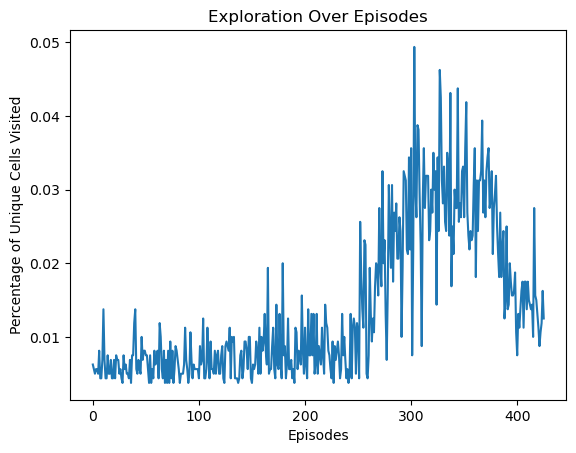

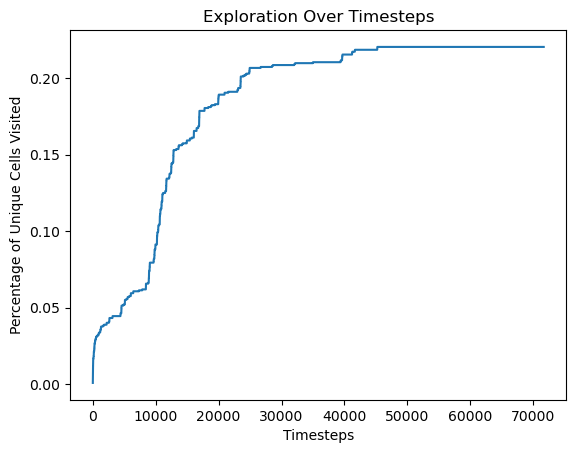

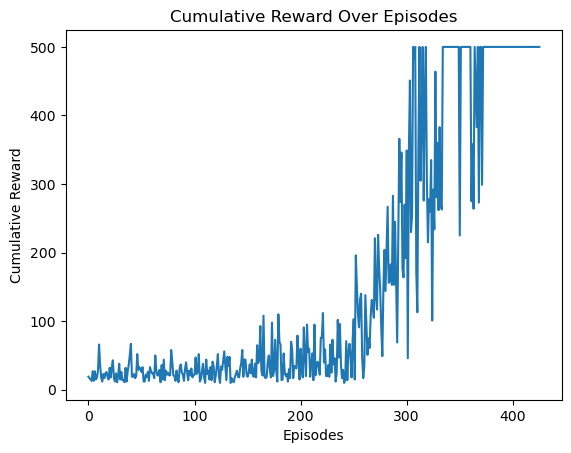

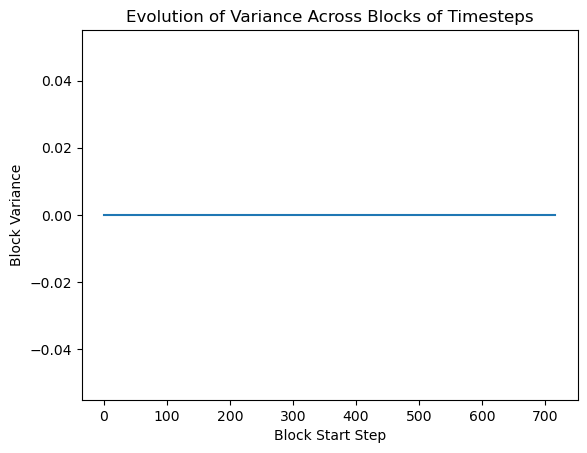

In [10]:
# Plotting additional statistics
cells_callback.plot_percentage_over_episodes()
cells_callback.plot_percentage_over_timesteps()
rewards_callback.plot_cumulative_rewards_over_episodes()
rewards_callback.plot_block_variances()

Variance of rewards is always 0 in this environment because a reward of +1 is assigned to the agent for every step taken, including the termination step